In [1]:
import torch
import scvi
import pandas as pd
import numpy as np
import scanpy as sc
import scgen
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import FeatureAblation

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

Global seed set to 0
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()
2023-02-02 16:26:52.131015: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-02 16:26:52.131070: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-02 16:26:52.131075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing librari

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.10.0 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.3 pynndescent==0.5.7


### load model and data

In [2]:
base_path = '../..'#'/home/icb/yuge.ji/projects/feature-attribution-sc'
adata = sc.read(f'{base_path}/datasets/2301_scgen_replogle22.h5ad')
adata

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 136498 × 1431
    obs: 'batch', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'guide_id', 'percent_mito', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'disease', 'cancer', 'cell_line', 'sex', 'age', 'perturbation', 'organism', 'perturbation_type', 'tissue_type', 'ncounts', 'ngenes', 'nperts', 'percent_ribo', 'perturbation_name', 'split', 'n_genes'
    var: 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'ensembl_id', 'ncounts', 'ncells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'perturbation_name_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [3]:
file = 'scgen_replogle22_model0_random_v2'
model = scgen.SCGEN.load(f'{base_path}/models/{file}', adata=adata)
model

INFO     File ../../models/scgen_replogle22_model0_random_v2/model.pt already downloaded     


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(


SCGEN Model with the following params: 
n_hidden: 400, n_latent: 30, n_layers: 2, dropout_rate: 0.2
Training status: Trained

get perturbation names that match the labels (integers in the model):

In [4]:
from scvi import REGISTRY_KEYS
pert_names = model.adata_manager.get_state_registry(REGISTRY_KEYS.BATCH_KEY)['categorical_mapping']

retrieve the data as a tensor from the dataloader. We'll define batch size to be the size of the whole dataset to do so.

In [5]:
# import numpy as np
indices = [np.array(sc.pp.subsample(adata[adata.obs.perturbation_name == c], n_obs=100, copy=True).obs.index) for c in adata.obs.perturbation_name.unique()]
adata = adata[list(np.array(indices).flatten())]
# adata.write('../../datasets/norman19_subset.h5ad')

# adata = sc.read('../../datasets/norman19_subset.h5ad')
# adata

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
# only for FA w.r.t. reconstruction
adata = adata[adata.obs.perturbation_name != 'control']

In [7]:
batch_size = adata.shape[0]

create a dataloader and load your first batch (in this case all the cells):

In [8]:
scdl = model._make_data_loader(adata=adata, indices=list(range(adata.shape[0])), batch_size=batch_size)
batch = next(scdl.__iter__())

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                  


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Measure feature attribution with respect to posterior

Wrap `model.module.forward` because captum has an internal check that the inputs pass are tensors. scGen does not use a nb loss by default so we only have a single reconstruction output, `px`.

In [7]:
# inference output is in [0], generative output is in [1]
forw = lambda x, y, z: model.module.forward({'X': x, 'batch':y, 'labels':z}, compute_loss=False)[1]['px']

In [8]:
# example output
model.module.forward(batch, compute_loss=False)[1]['px'].shape

torch.Size([2, 19018])

create the ablator, containing the forward function inside of it:

In [9]:
ablator = FeatureAblation(forw)

Run the feature attribution function. The attribution below outputs a tensor per input tensor. Using the first tensor, captum ablates the gene features one by one, for every cell, and has shape (n_cells * output_dim) * n_genes, where output_dim = n_genes because the output is the reconstructed cell. The other ablates the (biological) `batch` variable, which it takes as a single, continuous variable (even though it is a one-hot encoded (n_datasets)-dimensional variable), and therefore ablates it once per cell, and outputs a (n_cells * output_dim) * 1 shape tensor. The same thing happens for `labels`. We'll ignore both of these last two.

In [10]:
%%time
# per feature per output
attribution_map = ablator.attribute(
    (batch['X'], batch['batch'], batch['labels']),
    perturbations_per_eval=1,
    show_progress=True
)

Feature Ablation attribution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19021/19021 [2:39:50<00:00,  1.98it/s]


CPU times: user 1d 2h 36min 48s, sys: 9h 57min 46s, total: 1d 12h 34min 35s
Wall time: 2h 39min 51s


In [17]:
attribution_map_genes = attribution_map[0] # take only the first tensor (explained above)

reshape

In [22]:
output_dim = adata.shape[1]
attribution_map_genes_3d = attribution_map_genes.reshape((batch_size, output_dim, adata.shape[1]))  # need to check where things actually end up after the reshape

TODO: save attribution map

For each perturbation, calculate the mean absolute feature importance score per gene across all reconstructed features, ignoring other cells. Reasoning: the expression level of the gRNA target should have the greatest impact on the expression levels of all other genes, in those cells which were exposed to the gRNA. We take the absolute because the impact of the feature could have been positive or negative on gene expression.

In [26]:
attribution_map_genes_3d.mean()

tensor(2.0820e-05)

In [27]:
attribution_map_genes_3d.max()

tensor(0.8836)

In [28]:
attribution_map_genes_3d.min()

tensor(-0.1480)

In [29]:
attribution_map_genes.shape

torch.Size([38036, 19018])

TODO: switch this to be a loss-based reconstruction because the feature importance score matrix is infeasibly large

In [11]:
# means = pd.DataFrame(index=adata.var_names,columns=ct_names)

In [12]:
# for ct in batch['labels'].unique():
#     ct_float = ct.item()
#     ct_int = int(ct_float)
#     ct_indexing = (batch['labels'] == ct_float).reshape(-1)
#     means.iloc[:,ct_int] = torch.mean(attribution_map_genes_3d[ct_indexing,ct_int,:],dim=0)

### measure against latent

Wrap `model.module.inference` because captum expects a single tensor output, and scGen's inference returns a `z`, `qz_m`, and `qz_v`.

In [9]:
forw = lambda x: model.module.inference(x)['z']

In [10]:
ablator = FeatureAblation(forw)

Run the feature attribution function. Captum ablates the gene features one by one, for every cell, and has shape (n_cells * output_dim) * n_genes, where output_dim = latent_dim because the output is the latent representation.

In [11]:
%%time
attribution_map = ablator.attribute(
    batch['X'],
    perturbations_per_eval=1,  # change after bug fix PR
    show_progress=True
)

Feature Ablation attribution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1432/1432 [39:19<00:00,  1.65s/it]

CPU times: user 7h 53min 56s, sys: 5h 30min 2s, total: 13h 23min 59s
Wall time: 39min 19s


In [12]:
attribution_map.shape

torch.Size([1227000, 1431])

reshape

In [13]:
output_dim = 30
attribution_map_genes_3d = attribution_map.reshape((batch_size, output_dim, adata.shape[1]))  # need to check where things actually end up after the reshape

In [14]:
attribution_map_genes_3d.shape

torch.Size([40900, 30, 1431])

In [15]:
with open('attribution_map_genes_3d_replogle.npy', 'wb') as f:
    np.save(f, attribution_map_genes_3d)

We want to examine what happens per latent element later, but for now we'll just take the absolute average.

In [16]:
attribution_map_genes_3d.mean()

tensor(0.0009)

In [17]:
attribution_map_genes_3d.min()

tensor(-9.6564)

In [18]:
attribution_map_genes_3d.max()

tensor(13.8509)

Collapse the outputs to get 1 score per gene per **cell**, using the mean of absolute scores.

In [19]:
attribution_map_collapsed = attribution_map_genes_3d.abs().mean(1)

Examine the changes to min and max. A large decrease indicates that genes(features) were largely specific to a single latent dimension.

In [20]:
attribution_map_collapsed.min()

tensor(0.0044)

In [21]:
attribution_map_collapsed.max()

tensor(4.3023)

Take the average contribution per gene per **perturbation** to get a ranking of all genes per perturbation.

In [22]:
means = pd.DataFrame(index=adata.var_names, columns=pert_names)

In [23]:
for pert in batch['batch'].unique():
    pert_float = pert.item()
    pert_int = int(pert_float)
    pert_indexing = (batch['batch'] == pert_float).reshape(-1)
    means.iloc[:, pert_int] = attribution_map_collapsed[pert_indexing].mean(0).numpy()

/tmp/ipykernel_2738712/1885614425.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  means.iloc[:, pert_int] = attribution_map_collapsed[pert_indexing].mean(0).numpy()


In [24]:
means.head(5)

,AAAS,AATF,ABCE1,ABCF1,ACTR1B,ACTR2,ACTR8,AHCTF1,ALG1L,ALG2,...,YEATS4,YTHDC1,ZMAT2,ZNF207,ZNF284,ZNF468,ZNF574,ZNF687,ZNF718,control
gene_name,,,,,,,,,,,,,,,,,,,,,
HES4,0.013942,0.013485,0.015480,0.014393,0.014100,0.014732,0.014192,0.014761,0.014290,0.013943,...,0.013552,0.014985,0.013241,0.014115,0.013352,0.013586,0.013449,0.013137,0.014503,NaN
ISG15,0.015608,0.016989,0.016800,0.016680,0.014985,0.013955,0.017001,0.016487,0.014732,0.017171,...,0.014533,0.017859,0.014259,0.015973,0.015218,0.014820,0.014622,0.015783,0.015060,NaN
MXRA8,0.012395,0.012856,0.014226,0.012989,0.012476,0.011896,0.011922,0.012363,0.012318,0.012249,...,0.012069,0.012036,0.011777,0.012284,0.012324,0.012070,0.012692,0.012454,0.012000,NaN
SMIM1,0.012385,0.012089,0.011910,0.011683,0.011987,0.011902,0.012195,0.012961,0.011729,0.011997,...,0.011861,0.014490,0.012117,0.012696,0.012001,0.012731,0.012153,0.012987,0.011853,NaN
SRM,0.189088,0.229542,0.177698,0.183744,0.195686,0.200275,0.179984,0.179146,0.195968,0.184214,...,0.208660,0.180157,0.186062,0.184115,0.197147,0.190125,0.195328,0.186620,0.198421,NaN


AttributeError: 'float' object has no attribute 'dtype'

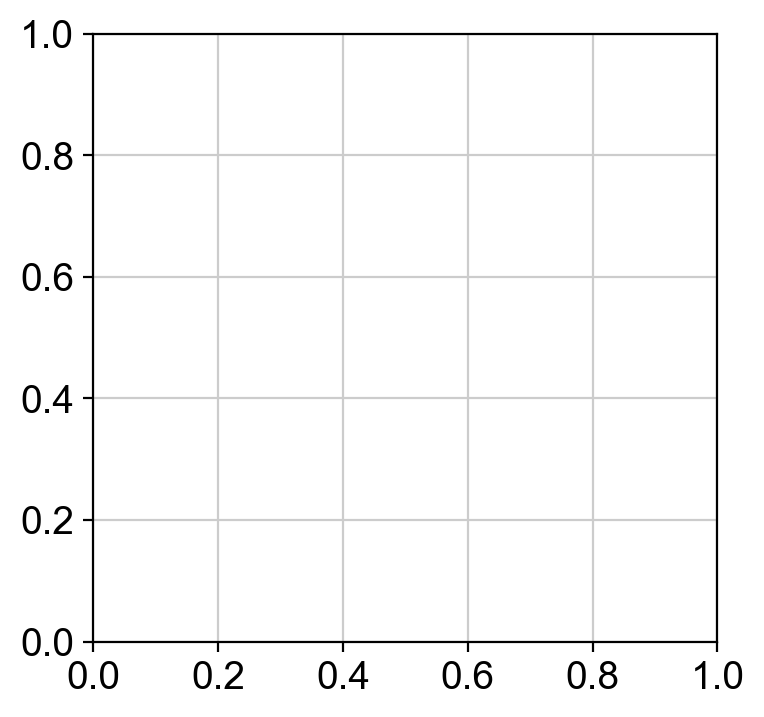

In [25]:
plt.hist(means['control'].values)
plt.yscale('log')

We can also repeat this for every latent space output to get latent feature specific importance distributions. This might be interesting to look at in the case in which one dimension of the latent space mostly captures a certain set of features.

In [26]:
slice_distr = pd.DataFrame(index=adata.var_names, columns=list(range(output_dim)))
for i in range(output_dim):
    attribution_map_slice = attribution_map_genes_3d[:, i, :]
    slice_distr.iloc[:, i] = attribution_map_slice.abs().mean(0).numpy()

/tmp/ipykernel_2738712/650637440.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  slice_distr.iloc[:, i] = attribution_map_slice.abs().mean(0).numpy()


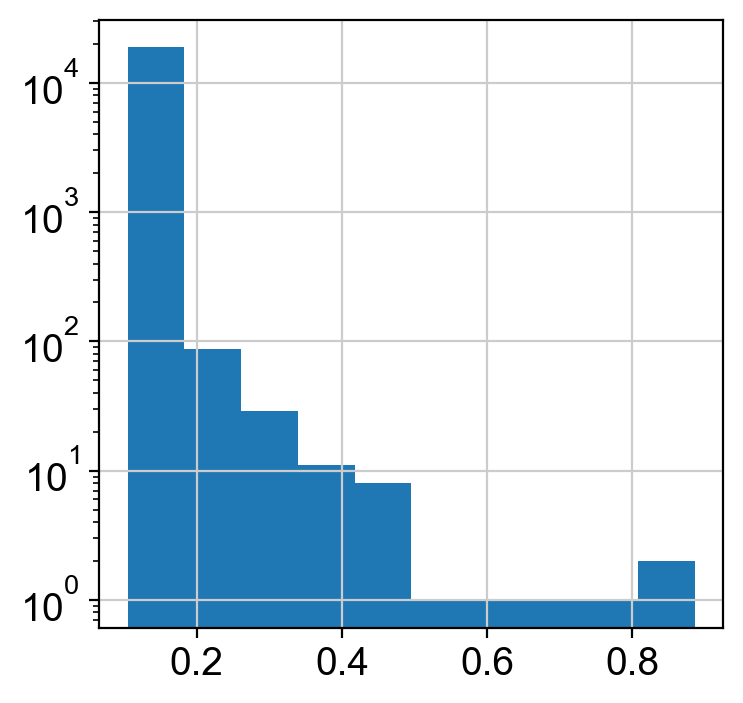

In [103]:
plt.hist(attribution_map_slice.abs().mean(0).numpy())
plt.yscale('log')

In [104]:
slice_distr.nlargest(100, 0)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
gene_symbols,,,,,,,,,,,,,,,,,,,,,
HBG2,0.769046,0.446218,0.191036,0.140578,0.272801,0.231617,0.556467,0.851015,0.408259,0.152479,...,0.276123,0.185214,0.828912,0.421060,0.831673,0.615337,0.161085,0.178604,0.235578,0.232180
MALAT1,0.726802,0.642232,1.264473,2.062182,0.871123,0.818863,0.615344,0.906070,2.757656,0.985994,...,0.591998,1.274109,0.676928,1.173751,0.437571,1.494212,2.171228,0.924419,0.675251,0.348091
TMSB4X,0.720068,0.296797,0.198145,0.122289,0.195740,0.189190,0.112363,0.376410,0.114536,0.135485,...,0.265183,0.246927,0.101933,0.207251,0.240522,0.290521,0.302640,0.287184,0.153120,0.317944
HBZ,0.635301,0.715284,0.314518,0.575590,0.768545,0.437674,0.998341,1.100581,0.537339,0.245906,...,0.376551,0.227928,1.473887,0.177697,0.610459,1.033401,0.164378,0.162329,0.317311,0.514574
NEAT1,0.458308,0.326596,0.440635,0.596738,0.512951,0.528120,0.415196,0.415023,0.725043,0.366373,...,0.487170,0.757675,0.140679,0.336315,0.204663,0.214751,0.418478,0.349372,0.149642,0.205666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NACA,0.177161,0.389879,0.188974,0.136850,0.334604,0.377322,0.196204,0.226614,0.160127,0.345786,...,0.268949,0.316490,0.115020,0.177626,0.289671,0.423730,0.187199,0.304179,0.118702,0.152245
RPS26,0.176621,0.192833,0.172423,0.271483,0.149632,0.184645,0.261847,0.760477,0.324634,0.170133,...,0.214773,0.142981,0.418480,0.176859,0.130217,0.192740,0.120035,0.176230,0.217050,0.184349
POMP,0.176286,0.215913,0.206248,0.148966,0.147704,0.234274,0.127482,0.397118,0.135637,0.204031,...,0.154990,0.190387,0.199108,0.158170,0.125045,0.149894,0.250530,0.225375,0.168601,0.157382


Check that they are anticorrelated as we would expect. Why do we not see any negative correlations..? Maybe it's because I only have control samples in here...

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


<AxesSubplot: >

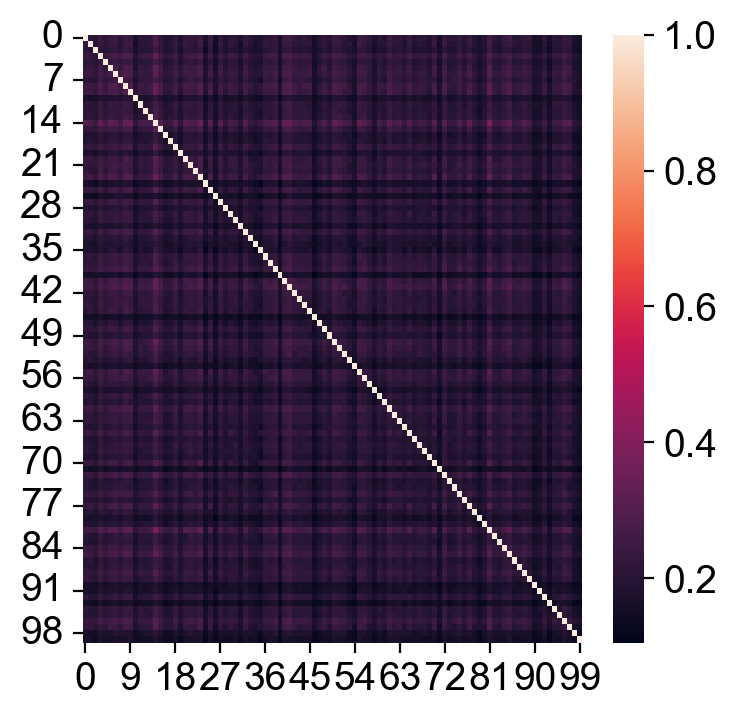

In [105]:
sns.heatmap(slice_distr.corr('spearman'))

Store results.

In [27]:
means.to_csv("../../outputs/ablation/task1.5_latent.csv")